# Machine Learning Engineer Nanodegree Program 

### Capstone Project : Object Detection, Classification and Recognition of Corvette Generations

#### By: Joel Haas
#### October 2019

This is an object detection, classification and recognition project.  Large areas of research include object detection, classification, and recognition.  Object detection is processing an image and detecting discreet objects within that image.  Object classification is taking the objects detected and identifying what those objects are.  And finally, object recognition is taking those classified objects and recognizing the differences between them.  Object recognition is the most difficult of the three mentioned, but nevertheless, there is a lot of research in these areas.

It is this technology that enables companies like Apple to use face recognition to unlock a user’s iPhone.  The iPhone detects a face, classifies it as a human face, and then recognizes that the human face is the owner of the phone.  It’s an exciting area of research that I would like to improve in. 

### Problem Statement ###

My project is an object detection, classification and recognition project.  Given an image as input, I want to detect whether a car is in the image or not, classify the car as a corvette or not, and if it is a corvette, recognize the specific generation of corvette – C1 through C8.  

### Datasets & Inputs

The data for this project consists of thousands of images.  There need to be thousands of images without cars and thousands of images for each generation of corvette.  

In a separate jupyter notebook, I scraped the web for enough images for training, validation and testing.  I scraped over 1,000 images of each generation of corvette.  I scraped over 2,700 images without a car.  And I downloaded a dataset of over 8,000 cars. 

Also in a separate jupyter notebook, I created a labeled dataset that I could use for predictions.

### Solution Statement 

I first collected the data.  Then I labeled the data.  Then I experimented with different ways to predict the classifications of the images.  Once I decided on the best path forward for classification, I built a convolutional neural network (CNN) architecture, trained and tested the model.  I then leveraged transfer learning to see if I could improve my predictions.  

### Benchmark Model

In the classification method I finally settled on, there are 10 classification labels: 
* not car, not corvette
* car, not corvette
* car, corvette, c1
* car, corvette, c2
* car, corvette, c3
* car, corvette, c4
* car, corvette, c5
* car, corvette, c6
* car, corvette, c7
* car, corvette, c8

As such, random guessing would result in a 10% probably of accurately predicting the correct classification.  

<b> Benchmark Model: </b> The CNN model that I build from the ground up serves as my benchmark model for performance.  

The goal is that the CNN model I build would be better than random guessing.

The next goal is that by using Transfer Learning, I would further improve model performance.

### Evaluation Metrics

I used accuracy as the evaluation metric to quantify the performance of both the benchmark model and the final solution model.  



## Import Python Libraries ##

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

from keras.preprocessing import image
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn import preprocessing

from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Import Training Data

In [2]:
# path to the project folder
path = r"labels"

# ingest subset of training data
#train = pd.read_csv(path + '/labels_training_data.csv')

# ingest full set of training data
train = pd.read_csv(path + '/labels_full_training_data.csv')

In [3]:
# view training data
train.head()

,id,car,corvette,c1,c2,c3,c4,c5,c6,c7,c8,classification
0,cars_1_0_0_ (1).jpg,1,0,0,0,0,0,0,0,0,0,"['car', 'not_corvette']"
1,cars_1_0_0_ (10).jpg,1,0,0,0,0,0,0,0,0,0,"['car', 'not_corvette']"
2,cars_1_0_0_ (100).jpg,1,0,0,0,0,0,0,0,0,0,"['car', 'not_corvette']"
3,cars_1_0_0_ (1000).jpg,1,0,0,0,0,0,0,0,0,0,"['car', 'not_corvette']"
4,cars_1_0_0_ (1001).jpg,1,0,0,0,0,0,0,0,0,0,"['car', 'not_corvette']"


In [4]:
# shape of the training data
train.shape

(17676, 12)

## One Hot Encode the Target Labels

By one hot encoding the target labels, we can predict the unique combination we are trying to predict, e.g. "car, corvette, c1" or "car, not corvette".

In [5]:
# One hot encode the classification column. Unique classifications become their own unique column with
#   1's and 0's 
labels = pd.get_dummies(train['classification'])
labels.head()

,"['car', 'corvette', 'c1']","['car', 'corvette', 'c2']","['car', 'corvette', 'c3']","['car', 'corvette', 'c4']","['car', 'corvette', 'c5']","['car', 'corvette', 'c6']","['car', 'corvette', 'c7']","['car', 'corvette', 'c8']","['car', 'not_corvette']","['not_car', 'not_corvette']"
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0


In [6]:
# combine the one hot encoded classifications with the image id's to create
#   a new dataset of image IDs with the one hot encoded classifications
train = pd.concat([train['id'], labels], axis=1)

In [7]:
#view shape of the dataframe
train.shape

(17676, 11)

In [8]:
# Training data set is now image id's plus the one hot encoded classifications
#    We will use the IDs to ingest the images. The classifications will become
#    the targets we will predict.
train[50:100]

,id,"['car', 'corvette', 'c1']","['car', 'corvette', 'c2']","['car', 'corvette', 'c3']","['car', 'corvette', 'c4']","['car', 'corvette', 'c5']","['car', 'corvette', 'c6']","['car', 'corvette', 'c7']","['car', 'corvette', 'c8']","['car', 'not_corvette']","['not_car', 'not_corvette']"
50,cars_1_0_0_ (1043).jpg,0,0,0,0,0,0,0,0,1,0
51,cars_1_0_0_ (1044).jpg,0,0,0,0,0,0,0,0,1,0
52,cars_1_0_0_ (1045).jpg,0,0,0,0,0,0,0,0,1,0
53,cars_1_0_0_ (1046).jpg,0,0,0,0,0,0,0,0,1,0
54,cars_1_0_0_ (1047).jpg,0,0,0,0,0,0,0,0,1,0
55,cars_1_0_0_ (1048).jpg,0,0,0,0,0,0,0,0,1,0
56,cars_1_0_0_ (1049).jpg,0,0,0,0,0,0,0,0,1,0
57,cars_1_0_0_ (105).jpg,0,0,0,0,0,0,0,0,1,0
58,cars_1_0_0_ (1050).jpg,0,0,0,0,0,0,0,0,1,0
59,cars_1_0_0_ (1051).jpg,0,0,0,0,0,0,0,0,1,0


## Load and Pre-Process the Images 

We need to read in each image and pre-process it for our neural network.  The output is an array where each image is the same size and with pixel values between 0 and 1.   

In [9]:
### Function to Load and Pre-Process the Images ###
def preprocess(data, sub_dir):
    """Input: dataframe with image IDs and the one hot encoded classifications
       Output: a numpy array with all the images pre-processed"""
    
    train_image = []
    for i in tqdm(range(data.shape[0])):
        try:
            # load each image and resize
            img = image.load_img(sub_dir + data['id'][i], target_size=(400,400,3))
            
            # convert image to an array
            img = image.img_to_array(img)
            
            # divide image by 255 so values are between 0 and 1 
            img = img/255
            
            # add the processed image to a list
            train_image.append(img)
        except:
            print(i)
    
    # convert the list of preprocessed images to a numpy array
    X = np.array(train_image)
    
    return X


In [10]:
# directory with the subset of images for training
#sub_dir_train = r'images/dataSet_training//'

# directory with the full set of images for training
sub_dir_train = r'images/dataSet//'

# Input to function: dataframe with image IDs and the location of the folder
# Output is a numpy array with all the images pre-processed
X = preprocess(train, sub_dir_train)

 78%|███████▊  | 13770/17676 [03:46<04:09, 15.66it/s]/usr/local/lib/python3.5/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
100%|██████████| 17676/17676 [05:32<00:00, 53.23it/s]


In [11]:
# view shape of the preprocessed images we will use for training
X.shape

(17676, 400, 400, 3)

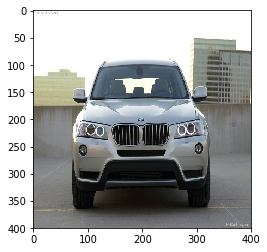

In [12]:
# view one of the images
plt.imshow(X[74])

## Prepare the Target for our Predictive Model

Our target is the one hot encoded classifications

In [13]:
# drop the ID column so that only the one hot encoded classifications remain
y = np.array(train.drop(['id'], axis=1))
y.shape

(17676, 10)

In [14]:
y

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

## Build the Model

We have our preprocessed training set and we have our targets.  We need to split our dataset into training and validation sets.  And then we need to build a CNN to classify our images.  We first build a CNN from scratch and measure it's performance against a hold-out test set of images.

In [15]:
### Create a validation set to check performance of our model on unseen data ###
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=32, test_size=0.20)

In [16]:
### Build the Model's Architecture ###
model = Sequential()
model.add(Conv2D(filters=16, strides=1, kernel_size=2, padding='same',activation='relu', input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.20))
model.add(Conv2D(filters=32, strides=2, kernel_size=2, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.20))         
model.add(Conv2D(filters=64, strides=2, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
          
# reduce dimensionality and reduce overfitting
model.add(GlobalAveragePooling2D(data_format=None))

# flatten the array into a vector and align the number of nodes with the 
#   number of target variables (10)
model.add(Dense(10, activation='sigmoid'))


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 400, 400, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
__________

In [18]:
# Compile the model with the selected parameters
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# set the number of epochs to run
epochs = 10

# save the best model
checkpointer = ModelCheckpoint(filepath='saved_models', 
                               verbose=1, save_best_only=True)

In [20]:
# Fit the model to the training set and test with the validation set
model.fit(X_train, y_train, epochs=epochs, 
          validation_data=(X_val, y_val), 
          batch_size=20, verbose=1,
         callbacks=[checkpointer])

Train on 14140 samples, validate on 3536 samples
Epoch 1/10
14140/14140 [==============================] - 367s - loss: 0.2645 - acc: 0.9039 - val_loss: 0.2437 - val_acc: 0.9152
Epoch 2/10
14140/14140 [==============================] - 366s - loss: 0.2345 - acc: 0.9198 - val_loss: 0.2363 - val_acc: 0.9199
Epoch 3/10
14140/14140 [==============================] - 365s - loss: 0.2317 - acc: 0.9214 - val_loss: 0.2320 - val_acc: 0.9203
Epoch 4/10
14140/14140 [==============================] - 366s - loss: 0.2296 - acc: 0.9226 - val_loss: 0.2317 - val_acc: 0.9208
Epoch 5/10
14140/14140 [==============================] - 366s - loss: 0.2266 - acc: 0.9233 - val_loss: 0.2303 - val_acc: 0.9217
Epoch 6/10
14140/14140 [==============================] - 365s - loss: 0.2249 - acc: 0.9241 - val_loss: 0.2267 - val_acc: 0.9228
Epoch 7/10
14140/14140 [==============================] - 366s - loss: 0.2229 - acc: 0.9250 - val_loss: 0.2259 - val_acc: 0.9230
Epoch 8/10
14140/14140 [========================

In [21]:
from keras.models import load_model

In [22]:
# save model as an HDF5 file
model.save('my_model.h5')

In [23]:
# load the compiled model
model = load_model('my_model.h5')

## Pre-Process Hold-out Test Set 

Now we have our model built on our test and validation sets. We need to pre-process our test set of images just like we did our training set. 

In [24]:
## Test Data Set
test_data = pd.read_csv("labels/labels_test_data.csv")
test_data.head()

,id,car,corvette,c1,c2,c3,c4,c5,c6,c7,c8,classification
0,cars_1_0_0_ (44).jpg,1,0,0,0,0,0,0,0,0,0,"['car', 'not_corvette']"
1,cars_1_0_0_ (45).jpg,1,0,0,0,0,0,0,0,0,0,"['car', 'not_corvette']"
2,cars_1_0_0_ (46).jpg,1,0,0,0,0,0,0,0,0,0,"['car', 'not_corvette']"
3,cars_1_0_0_ (47).jpg,1,0,0,0,0,0,0,0,0,0,"['car', 'not_corvette']"
4,cars_1_0_0_ (48).jpg,1,0,0,0,0,0,0,0,0,0,"['car', 'not_corvette']"


In [25]:
test_data.shape

(486, 12)

In [26]:
# one hot encode the classification labels
true_labels_test = pd.get_dummies(test_data['classification'])
true_labels_test.head()

,"['car', 'corvette', 'c1']","['car', 'corvette', 'c2']","['car', 'corvette', 'c3']","['car', 'corvette', 'c4']","['car', 'corvette', 'c5']","['car', 'corvette', 'c6']","['car', 'corvette', 'c7']","['car', 'corvette', 'c8']","['car', 'not_corvette']","['not_car', 'not_corvette']"
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0


In [27]:
# combine the image IDs with the one hot encoded target labels
test_set = pd.concat([test_data['id'], true_labels_test], axis=1)
test_set.head()

,id,"['car', 'corvette', 'c1']","['car', 'corvette', 'c2']","['car', 'corvette', 'c3']","['car', 'corvette', 'c4']","['car', 'corvette', 'c5']","['car', 'corvette', 'c6']","['car', 'corvette', 'c7']","['car', 'corvette', 'c8']","['car', 'not_corvette']","['not_car', 'not_corvette']"
0,cars_1_0_0_ (44).jpg,0,0,0,0,0,0,0,0,1,0
1,cars_1_0_0_ (45).jpg,0,0,0,0,0,0,0,0,1,0
2,cars_1_0_0_ (46).jpg,0,0,0,0,0,0,0,0,1,0
3,cars_1_0_0_ (47).jpg,0,0,0,0,0,0,0,0,1,0
4,cars_1_0_0_ (48).jpg,0,0,0,0,0,0,0,0,1,0


In [28]:
test_set.shape

(486, 11)

In [29]:
### Load and preprocess test data

# directory path for our test set
sub_dir_test = r'images/testSet//'

# preprocess the test set and return an array
X_test = preprocess(test_data, sub_dir_test)
X_test

100%|██████████| 486/486 [00:10<00:00, 44.99it/s]


array([[[[ 0.97647059,  1.        ,  0.99215686],
         [ 0.97647059,  1.        ,  0.99215686],
         [ 0.97647059,  1.        ,  0.99215686],
         ..., 
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        [[ 0.97647059,  1.        ,  0.99215686],
         [ 0.97647059,  1.        ,  0.99215686],
         [ 0.97647059,  1.        ,  0.99215686],
         ..., 
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        [[ 0.97647059,  1.        ,  0.99215686],
         [ 0.97647059,  1.        ,  0.99215686],
         [ 0.97647059,  1.        ,  0.99215686],
         ..., 
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],

        ..., 
        [[ 0.50588238,  0.56470591,

In [30]:
# view shape of the test set
X_test.shape

(486, 400, 400, 3)

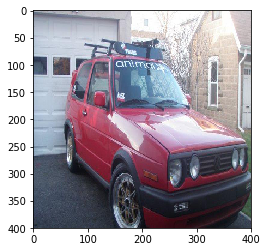

In [31]:
# view one of the images in the test set after pre-processing
plt.imshow(X_test[1])

In [32]:
# Prepare target labels for the test set
y_true_labels = np.array(test_set.drop(['id'], axis=1))
y_true_labels.shape

(486, 10)

In [33]:
y_true_labels

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

## Make Predictions

Using the CNN model we built, we can now make predictions on our hold out test set.  We measure the performance of our model by calculating the model's accuracy.

In [34]:
# iterate through the test set and make a prediction
corvette_predictions = [np.argmax(model.predict(np.expand_dims(image, axis=0))) for image in X_test]

In [35]:
# compare the predictions to the true classification and calculate 
#   the total accuracy
test_accuracy = (100 * np.sum(np.array(corvette_predictions)==np.argmax(y_true_labels, axis=1))) / len(corvette_predictions)
test_accuracy

20.164609053497941

## Results

Recall that random guessing would result in a 10% probability of accuracy (1 out of 10 chance).  The model we built is twice as good at 20% accuracy (1 out of 5 chance).  Other runs of this model reached 25% accuracy.  Either way, let's see if we can improve our performance by leveraging Transfer Learning. 

## Transfer Learning
Transfer Learning is used to leverage existing and complex architectures that have been shown to have great performance.  I leverage the weights of the pre-trained models and then add several of layers of my own that are specific to this project.  The last layer again will contain one node for each possible classification.

We will use two pre-trained models for comparison, VGG16 and ResNet50.  We start with VGG16. 

In [36]:
from keras.models import Model
from keras import applications
from keras.layers import Input

In [37]:
# specify the size of the input tensor based on the image reshape size
#  we did previously
input_tensor = Input(shape=(400,400,3))

## VGG16

Create a CNN using VGG16

In [38]:
# load VGG16 neural network and exclude the output layers
base_model = applications.VGG16(weights='imagenet', 
                                 include_top=False,
                                input_tensor=input_tensor)

In [39]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
__________

In [40]:
x = base_model.output
x

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 12, 12, 512) dtype=float32>

In [41]:
# Add additional layers to the VGG16 CNN architecture
x = GlobalAveragePooling2D()(x)
preds = Dense(10, activation='sigmoid')(x)

model_VGG16 = Model(inputs=base_model.input, outputs=preds)

In [42]:
# We want to use the pre-trained weights of VGG16, so set the 
#   weights to non-trainable.  And we want to train on the layers
#   we added
for layer in model_VGG16.layers[:20]:
    layer.trainable=False
for layer in model_VGG16.layers[20:]:
    layer.trainable=True

In [43]:
# View the additional layers I added to the VGG16 architecture
model_VGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
__________

In [44]:
# Compile the model with the selected parameters
model_VGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
# set the number of epochs to run
epochs = 5

# save the best model
#checkpointer = ModelCheckpoint(filepath=path+'saved_models', 
#                               verbose=1, save_best_only=True)

In [50]:
# Fit the model to the training set and test with the validation set
model_VGG16.fit(X_train, y_train, epochs=epochs, 
          validation_data=(X_val, y_val), 
          batch_size=20, verbose=1)

         #callbacks=[checkpointer])

Train on 14140 samples, validate on 3536 samples
Epoch 1/5
14140/14140 [==============================] - 6543s - loss: 0.1686 - acc: 0.9438 - val_loss: 0.1618 - val_acc: 0.9455
Epoch 2/5
14140/14140 [==============================] - 6543s - loss: 0.1571 - acc: 0.9462 - val_loss: 0.1520 - val_acc: 0.9468
Epoch 3/5
14140/14140 [==============================] - 6543s - loss: 0.1483 - acc: 0.9481 - val_loss: 0.1445 - val_acc: 0.9491
Epoch 4/5
14140/14140 [==============================] - 6541s - loss: 0.1412 - acc: 0.9496 - val_loss: 0.1389 - val_acc: 0.9499
Epoch 5/5
14140/14140 [==============================] - 6541s - loss: 0.1354 - acc: 0.9509 - val_loss: 0.1334 - val_acc: 0.9516


In [51]:
# save model as an HDF5 file
model_VGG16.save('VGG16_model.h5')

In [52]:
# load the compiled model
model_VGG16 = load_model('VGG16_model.h5')

In [53]:
# iterate through the test set and make a prediction
corvette_predictions = [np.argmax(model_VGG16.predict(np.expand_dims(image, axis=0))) for image in X_test]

# compare the predictions to the true classification and calculate 
#   the total accuracy
test_accuracy = (100 * np.sum(np.array(corvette_predictions)==np.argmax(y_true_labels, axis=1))) / len(corvette_predictions)
test_accuracy

47.942386831275719

## Result

The performance of this model, where we leveraged the VGG16 CNN architecture, resulted in slightly better performance than the CNN we built from scratch.  Whereas our model's performance hovers around 20% accuracy (1 out of 5), this model's performance is nearly 48% accuracy (1 out of 2)!  This is a dramatic improvement considering there are 10 unique classifications.  Now let's try another architecture. 

## ResNet50

Create a CNN using ResNet50 and keep the weights from the pre-trained model.

In [54]:
# load Resnet50 neural network and exclude the output layers
base_model_Resnet = applications.ResNet50(weights='imagenet', 
                                 include_top=False,
                                input_tensor=input_tensor)

In [55]:
base_model_Resnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 400, 400, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 406, 406, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 200, 200, 64)  9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 200, 200, 64)  256                                          
___________________________________________________________________________________________

In [56]:
# We want to use the pre-trained weights of ResNet50, so set the 
#   weights to non-trainable. 
for layer in base_model_Resnet.layers:
    layer.trainable=False

In [57]:
xR = base_model_Resnet.output

# Add additional layers to the Resnet50 CNN architecture
xR = GlobalAveragePooling2D()(xR)
predsR = Dense(10, activation='sigmoid')(xR)

model_Resnet50 = Model(inputs=base_model_Resnet.input, outputs=predsR)

In [58]:
# Compile the model with the selected parameters
model_Resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
# set the number of epochs to run
epochs = 5

# Fit the model to the training set and test with the validation set
model_Resnet50.fit(X_train, y_train, epochs=epochs, 
          validation_data=(X_val, y_val), 
          batch_size=20, verbose=1)

Train on 14140 samples, validate on 3536 samples
Epoch 1/5
14140/14140 [==============================] - 4374s - loss: 0.1668 - acc: 0.9435 - val_loss: 0.2111 - val_acc: 0.9357
Epoch 2/5
14140/14140 [==============================] - 4391s - loss: 0.1207 - acc: 0.9561 - val_loss: 0.1143 - val_acc: 0.9585
Epoch 3/5
14140/14140 [==============================] - 4391s - loss: 0.1057 - acc: 0.9612 - val_loss: 0.1099 - val_acc: 0.9611
Epoch 4/5
14140/14140 [==============================] - 4391s - loss: 0.0989 - acc: 0.9634 - val_loss: 0.1066 - val_acc: 0.9634
Epoch 5/5
14140/14140 [==============================] - 4398s - loss: 0.0914 - acc: 0.9666 - val_loss: 0.1029 - val_acc: 0.9646


In [60]:
# save model as an HDF5 file
model_Resnet50.save('Resnet50_model.h5')

In [64]:
# load the compiled model
model_Resnet50 = load_model('Resnet50_model.h5')

In [65]:
# iterate through the test set and make a prediction
corvette_predictions = [np.argmax(model_Resnet50.predict(np.expand_dims(image, axis=0))) for image in X_test]

# compare the predictions to the true classification and calculate 
#   the total accuracy
test_accuracy = (100 * np.sum(np.array(corvette_predictions)==np.argmax(y_true_labels, axis=1))) / len(corvette_predictions)
test_accuracy

72.63374485596708

## Result

The performance of this model is impressive!   An accuracy of 72% is wonderful given our 10 unique classifications.  

The ResNet50 architecture is more complicated than VGG16, so I'm not surprised it performs better.  I do wonder if we can still improve our model's performance by making some changes.  

The final hypothesis I tested can be found in notebook 'MLEND_Capstone_Main_Mod1_HaasJoel'.  The hypothesis is as follows:

* Leverage the ResNet50 architecture, but this time, what if I retrained the entire neural network to generate new weights? 
* Recall that in the current training data set, there are over 8,000 images of various car models and over 2,700 images without a car.  What if my training dataset included roughly 900 images of each classification?  Could the additional images of certain classifications result in an unwanted bias in the weights?
* What if my validation set was decreased from 0.20 to 0.10? 
* What if I decreased the number of epochs from 5 to 2? (cost and time to process have become critical constraints, unfortunately)